In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import mlflow
# import mlflow.keras
# import mlflow.sklearn
# import mlflow.tensorflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, fbeta_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from PIL import Image
import io


from transformers import BertTokenizer, BertForSequenceClassification


c:\AI Python\P7OC\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# print("CUDA built with TF :", tf.test.is_built_with_cuda())
# print("GPU available :", tf.config.list_physical_devices('GPU'))
# print("TF version :", tf.__version__)
# tf.config.list_physical_devices('GPU')

In [3]:
print(torch.cuda.is_available())

True


In [4]:
df = pd.read_csv(
    "datas/training.1600000.processed.noemoticon.csv",
    sep=",", encoding="latin-1", header=None
)
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df['target'] = df['target'].replace(4, 1)  # 4 → 1 (positif)

# Réduction du dataset
target0 = df[df['target'] == 0].sample(8000, random_state=42)
target1 = df[df['target'] == 1].sample(8000, random_state=42)
df_reduced = pd.concat([target0, target1]).sample(frac=1, random_state=42)

texts = df_reduced['text'].astype(str).values
labels = df_reduced['target'].values



In [5]:
all_idx = np.arange(len(df_reduced))
idx_train, idx_test = train_test_split(all_idx, test_size=0.2, random_state=42)

y_train = labels[idx_train]
y_test = labels[idx_test]


In [6]:
def simple_tokenize(text):
    # tokenize très basique, à adapter si besoin
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(texts, vocab_size=10000):
    counter = Counter()
    for t in texts:
        counter.update(simple_tokenize(t))
    most_common = counter.most_common(vocab_size - 2)  # -2 pour PAD et OOV
    word2idx = {"<PAD>": 0, "<OOV>": 1}
    for i, (w, _) in enumerate(most_common, start=2):
        word2idx[w] = i
    return word2idx

def texts_to_sequences(texts, word2idx):
    seqs = []
    for t in texts:
        tokens = simple_tokenize(t)
        ids = [word2idx.get(tok, 1) for tok in tokens]  # 1 = <OOV>
        seqs.append(ids)
    return seqs

def pad_sequences_numpy(seqs, maxlen):
    arr = np.zeros((len(seqs), maxlen), dtype="int64")
    for i, s in enumerate(seqs):
        s = s[:maxlen]
        arr[i, :len(s)] = s
    return arr

In [7]:
texts = df_reduced["text"].astype(str).values
labels = df_reduced["target"].values

all_idx = np.arange(len(df_reduced))
idx_train, idx_test = train_test_split(all_idx, test_size=0.2, random_state=42)
y_train = labels[idx_train]
y_test  = labels[idx_test]

word2idx = build_vocab(texts, vocab_size=10000)
sequences = texts_to_sequences(texts, word2idx)
max_len = 50
X_lstm = pad_sequences_numpy(sequences, max_len)

X_train_lstm = X_lstm[idx_train]
X_test_lstm  = X_lstm[idx_test]

In [8]:
# tokenizer_lstm = Tokenizer(num_words=10000, oov_token="<OOV>")
# tokenizer_lstm.fit_on_texts(texts)

# sequences = tokenizer_lstm.texts_to_sequences(texts)
# max_len = 50

# X_lstm = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# X_train_lstm = X_lstm[idx_train]
# X_test_lstm = X_lstm[idx_test]

class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=64, hidden_dim=64, maxlen=50):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        x = self.dropout(hn[-1])
        return torch.sigmoid(self.fc(x)).squeeze()

In [9]:
vectorizer = TfidfVectorizer(max_features=10000)
X_lr = vectorizer.fit_transform(texts)

X_train_lr = X_lr[idx_train]
X_test_lr = X_lr[idx_test]


In [10]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_bert(texts, tokenizer, max_len=64):
    return tokenizer(
        list(texts),
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )

enc_train = encode_bert(df_reduced['text'].iloc[idx_train], tokenizer_bert)
enc_test = encode_bert(df_reduced['text'].iloc[idx_test], tokenizer_bert)

X_train_enc = {
    "input_ids": enc_train["input_ids"],
    "attention_mask": enc_train["attention_mask"]
}

X_test_enc = {
    "input_ids": enc_test["input_ids"],
    "attention_mask": enc_test["attention_mask"]
}



In [11]:
def plot_and_log_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title(f'Matrice de confusion - {model_name}')

    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    img = Image.open(buf)
    mlflow.log_image(img, f"confusion_matrix_{model_name}.png")




In [12]:
# def train_and_log_lstm():
#     with mlflow.start_run(run_name="LSTM"):
#         model = Sequential([
#             Embedding(input_dim=10000, output_dim=64, input_length=max_len),
#             LSTM(64, dropout=0.2, recurrent_dropout=0.2),
#             Dense(1, activation="sigmoid")
#         ])
#         model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#         model.fit(
#             X_train_lstm, y_train,
#             epochs=3,
#             batch_size=64,
#             validation_data=(X_test_lstm, y_test),
#             verbose=2
#         )

#         preds_proba = model.predict(X_test_lstm).flatten()
#         preds = (preds_proba > 0.5).astype(int)

#         mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
#         mlflow.log_metric("precision", precision_score(y_test, preds))
#         mlflow.log_metric("recall", recall_score(y_test, preds))
#         mlflow.log_metric("f1_score", f1_score(y_test, preds))
#         mlflow.log_metric("roc_auc", roc_auc_score(y_test, preds_proba))

#         mlflow.keras.log_model(model, "LSTM")

#         plot_and_log_confusion_matrix(y_test, preds, "LSTM")
#         print("LSTM logged successfully.")

def train_and_log_lstm_pytorch():
    with mlflow.start_run(run_name="LSTM-PyTorch"):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = LSTMSentiment(vocab_size=10000, embed_dim=64, hidden_dim=64, maxlen=50).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        # réutilise les variables 
        X_train_torch = torch.LongTensor(X_train_lstm).to(device)
        y_train_torch = torch.FloatTensor(y_train).to(device)
        X_test_torch  = torch.LongTensor(X_test_lstm).to(device)
        y_test_torch  = torch.FloatTensor(y_test).to(device)

        train_dataset = TensorDataset(X_train_torch, y_train_torch)
        train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

        model.train()
        for epoch in range(3):
            total_loss = 0.0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x).float()
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1}/3 - loss: {total_loss/len(train_loader):.4f}")

        # Évaluation
        model.eval()
        with torch.no_grad():
            preds_proba = model(X_test_torch).cpu().numpy()
            preds = (preds_proba > 0.5).astype(int)

        mlflow.log_metrics({
            "accuracy":  accuracy_score(y_test, preds),
            "precision": precision_score(y_test, preds),
            "recall":    recall_score(y_test, preds),
            "f1_score":   f1_score(y_test, preds),
            "f2_score":   fbeta_score(y_test, preds, beta=2),
            "roc_auc":    roc_auc_score(y_test, preds_proba),
        })
        mlflow.pytorch.log_model(model, "LSTM-PyTorch")
        plot_and_log_confusion_matrix(y_test, preds, "LSTM-PyTorch")
        print("LSTM PyTorch logged successfully.")


In [13]:
def train_and_log_lr():
    with mlflow.start_run(run_name="LogReg_TFIDF"):
        model = LogisticRegression(max_iter=200)
        model.fit(X_train_lr, y_train)

        preds = model.predict(X_test_lr)
        preds_proba = model.predict_proba(X_test_lr)[:, 1]

        mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
        mlflow.log_metric("precision", precision_score(y_test, preds))
        mlflow.log_metric("recall", recall_score(y_test, preds))
        mlflow.log_metric("f1_score", f1_score(y_test, preds))
        mlflow.log_metric("f2_score", fbeta_score(y_test, preds, beta=2))
        mlflow.log_metric("roc_auc", roc_auc_score(y_test, preds_proba))

        mlflow.sklearn.log_model(model, "LogReg_TFIDF")

        plot_and_log_confusion_matrix(y_test, preds, "LogReg_TFIDF")
        print("LogReg TF-IDF logged successfully.")



In [14]:
from torch.optim import AdamW


def train_and_log_bert():
    with mlflow.start_run(run_name="BERT"):
        # Vérification d'utilisation du GPU
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # Charge du model
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=2,
            use_safetensors=False
        ).to(device)

        optimizer = AdamW(model.parameters(), lr=2e-5)

        # DATASET + DATALOADER
        # y_train -> tensor long sur le bon device
        y_train_tensor = torch.LongTensor(y_train).to(device)

        train_dataset = TensorDataset(
            X_train_enc["input_ids"].to(device),
            X_train_enc["attention_mask"].to(device),
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        # phase d'entrainement
        model.train()
        for epoch in range(2):
            total_loss = 0.0
            for batch in train_loader:
                input_ids, attention_mask, labels = batch

                optimizer.zero_grad()
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}/2 - loss: {total_loss/len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits = model(
                input_ids=X_test_enc["input_ids"].to(device),
                attention_mask=X_test_enc["attention_mask"].to(device)
            ).logits

        # Conversion en numpy
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = np.argmax(logits.cpu().numpy(), axis=1)

        # Metrics
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        f2 = fbeta_score(y_test, preds, beta=2)
        roc = roc_auc_score(y_test, probs)

        mlflow.log_metrics({
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "f2_score": f2,
            "roc_auc": roc,
        })

        # Log le model
        mlflow.pytorch.log_model(model, "BERT")

        # Plot la matrice
        plot_and_log_confusion_matrix(y_test, preds, "BERT")

        print("BERT logged successfully.")


c:\AI Python\P7OC\env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/3 - loss: 0.6948
Epoch 2/3 - loss: 0.6938


c:\AI Python\P7OC\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
2025/12/11 20:17:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 3/3 - loss: 0.6934


2025/12/11 20:17:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/11 20:17:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/11 20:17:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LSTM PyTorch logged successfully.
🏃 View run LSTM-PyTorch at: http://127.0.0.1:8080/#/experiments/330540034538193051/runs/4ba8d6e95c2c44749657f70112efbf65
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/330540034538193051


2025/12/11 20:17:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/11 20:17:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogReg TF-IDF logged successfully.
🏃 View run LogReg_TFIDF at: http://127.0.0.1:8080/#/experiments/330540034538193051/runs/7e412ec3cc8b4f3590c5048786d957d8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/330540034538193051


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - loss: 0.4556
Epoch 2/2 - loss: 0.2839


2025/12/11 20:20:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/11 20:20:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/11 20:21:05 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/11 20:21:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

BERT logged successfully.
🏃 View run BERT at: http://127.0.0.1:8080/#/experiments/330540034538193051/runs/4e913f24e70b47f08206e5664f28de4b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/330540034538193051


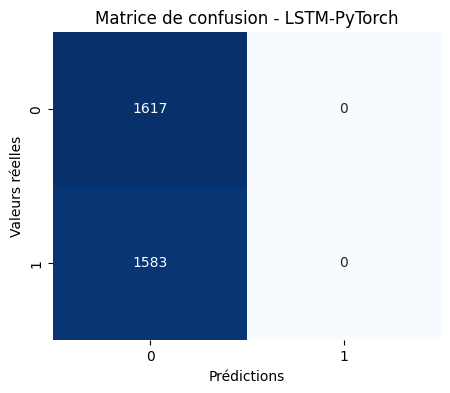

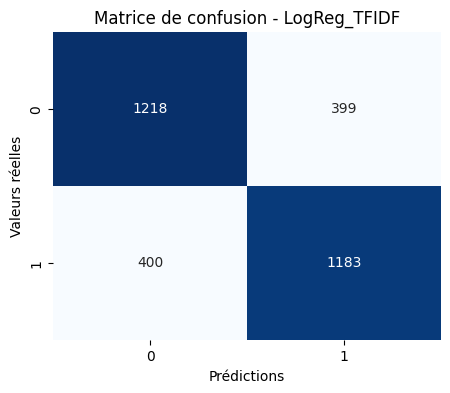

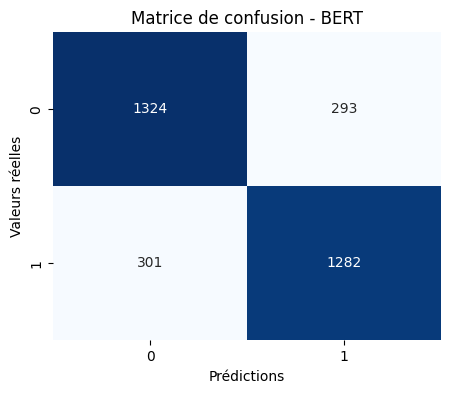

In [15]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Twitter_Sentiment_Models")

#train_and_log_lstm()
train_and_log_lstm_pytorch()
train_and_log_lr()
train_and_log_bert()
mlflow.end_run()

In [16]:
! nvidia-smi


Thu Dec 11 20:24:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.80                 Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  |   00000000:2B:00.0  On |                  N/A |
|  0%   47C    P8             21W /  270W |    7238MiB /   8192MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----